# การสำรวจข้อมูล
ควรตรวจสอบอยู่สามอย่าง (investigation):
1. Structure => dtype, shape of table, .describe(), unique, (for non-numerical and numerical)
2. Quality ==> missing values, duplicated
3. Content ==> pairplot, correlation, scatterplot (for non-numerical and numerical)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.datasets import fetch_openml

In [2]:
dataset = fetch_openml(data_id=42803, as_frame=True)

# Structure Investigation
dtype, shape of table, .describe(), unique, (for non-numerical and numerical)

In [3]:
df_X = dataset["frame"]
print(f'Shape: {df_X.shape}')
pd.value_counts(df_X.dtypes)

Shape: (363243, 67)


float64    61
object      6
dtype: int64

### Check non-numerical data
- Change "Date" and "Time" to a datetime column
- Change Sex_of_Driver to numerical

In [4]:
df_X.select_dtypes(exclude='number').head()

Accident_Index Sex_of_Driver        Date   Time Local_Authority_(Highway)  \
0  201501BS70001           1.0  12/01/2015  18:45                 E09000020   
1  201501BS70002           1.0  12/01/2015  07:50                 E09000020   
2  201501BS70004           1.0  12/01/2015  18:08                 E09000020   
3  201501BS70005           1.0  13/01/2015  07:40                 E09000020   
4  201501BS70008           1.0  09/01/2015  07:30                 E09000020   

  LSOA_of_Accident_Location  
0                 E01002825  
1                 E01002820  
2                 E01002833  
3                 E01002874  
4                 E01002814

In [5]:
# Change "Date" and "Time" to a datetime column
# df_X['datetime'] = df_X['Date'] + ' ' + df_X['Time']
# df_X['datetime'] = pd.to_datetime(df_X['datetime'])

# Change Sex_of_Driver to numerical
df_X['Sex_of_Driver'] = df_X['Sex_of_Driver'].astype('float') 

- Accident_Index: 201543P296025 เกิดบ่อยสุด
- วันวาเลนไทน์เกิดอบัติเหตุเยอะสุด 
- เวลา17.30เกิดอบัติเหตุเยอะสุด
- เส้นทาง และ ตำแหน่งที่เกิดบ่อที่สุด


In [6]:
df_X.describe(exclude="number", datetime_is_numeric=True)

Accident_Index        Date    Time Local_Authority_(Highway)  \
count          363243      319866  319822                    319866   
unique         140056         365    1439                       204   
top     201543P296025  14/02/2015   17:30                 E10000017   
freq             1332        2144    2972                      8457   

       LSOA_of_Accident_Location  
count                     298758  
unique                     25979  
top                    E01028497  
freq                        1456

### Check unique values
ยิ่งมีค่าที่ไม่ซ้ำกันมาก จะเป็นcontinous
ถ้ามีเลขที่ซ้ำกันบ่อยๆ มีไม่หลายหลากตัวเลข จะเป็น binary, ordinary

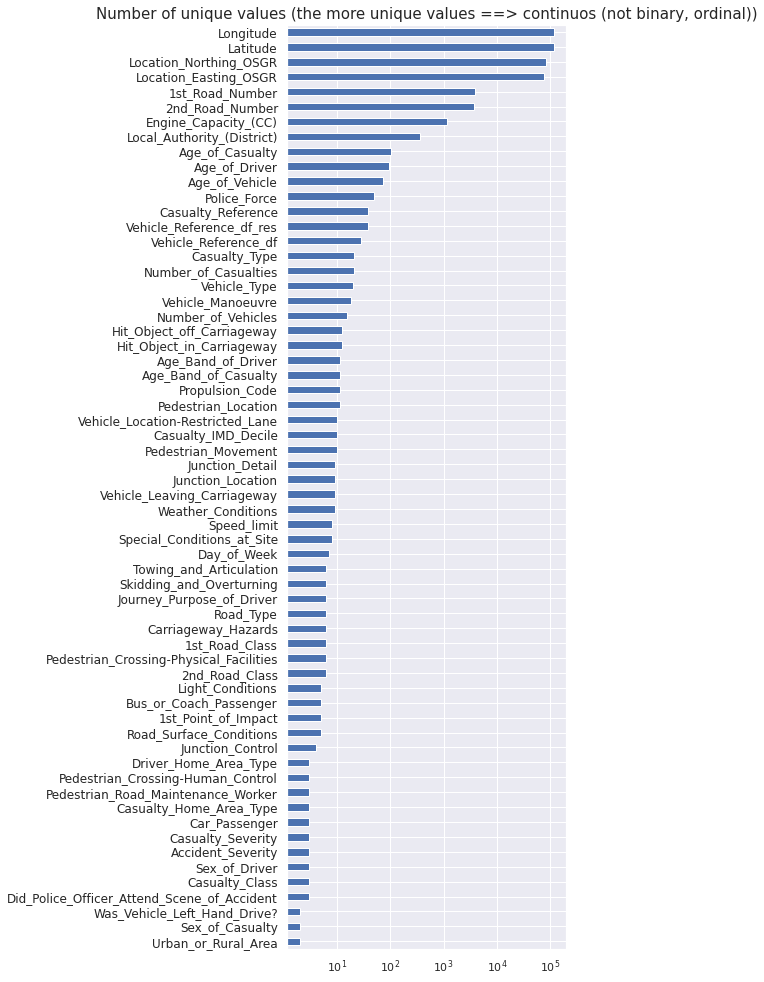

In [7]:
uni_val = df_X.select_dtypes(include='number').nunique().sort_values()
uni_val.plot(kind='barh', figsize=(5,17), logx=True)
plt.title('Number of unique values (the more unique values ==> continuos (not binary, ordinal))', size=15)
plt.yticks(size=12)
plt.show()

# Quality Investigation


In [8]:
# if not drop the index, there are no duplicated row
# มันยากที่จะเกิดสองเหตุการณ์ซ้ำกัน อาจจะมีคนบันทึกซ้ำกันพร้อนกันสองคน
print('There are duplicated instaces: ')
print(df_X.drop("Accident_Index", axis=1).duplicated().sum())
df_X = df_X.drop_duplicates(df_X.drop('Accident_Index', axis=1).columns)
print('Removed duplicate')

There are duplicated instaces: 
22
Removed duplicate


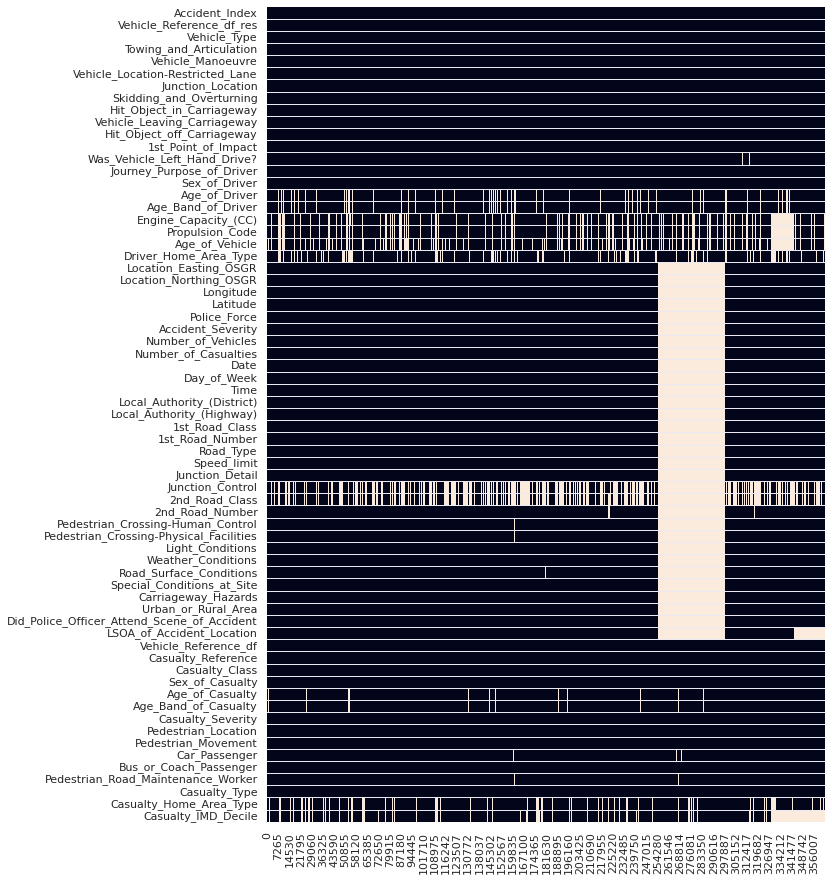

In [9]:
plt.figure(figsize=(10, 15))
sns.heatmap(data=df_X.isna().T, cbar=False)
plt.show()

### Drop rows that contain more than 20%

In [10]:
# Drop row that contain missing values more than 20% of columns
df_X = df_X.dropna(thresh=df_X.shape[1] * 0.80, axis=0).reset_index(drop=True)
df_X.shape

(319790, 67)

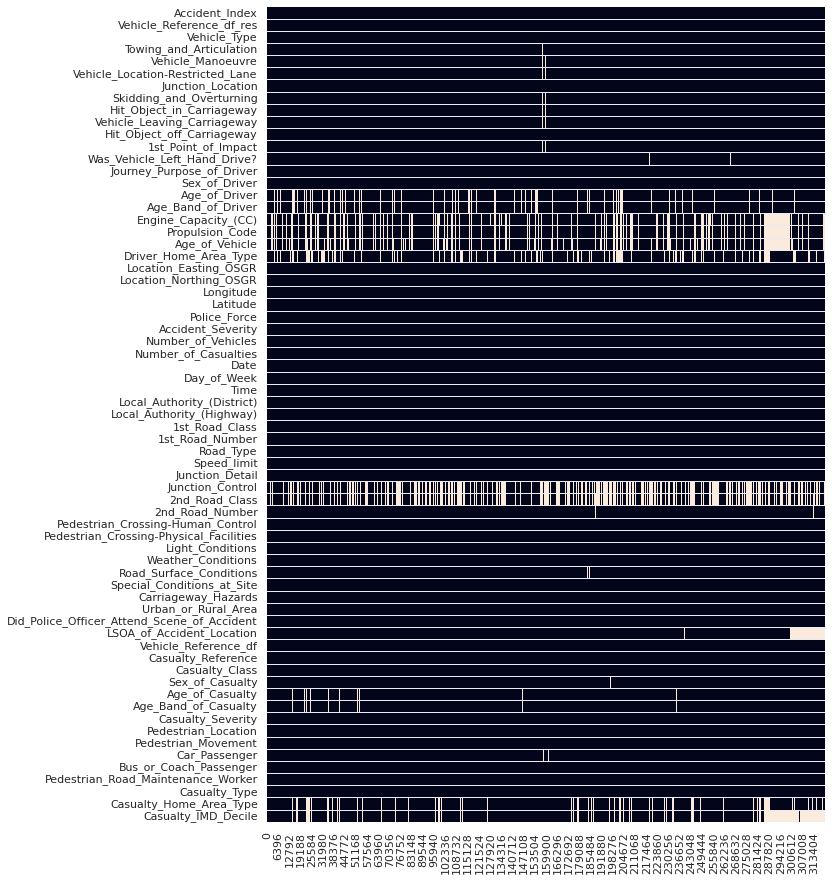

In [11]:
plt.figure(figsize=(10, 15))
sns.heatmap(data=df_X.isna().T, cbar=False)
plt.show()

### Drop columns that contain more than 15%

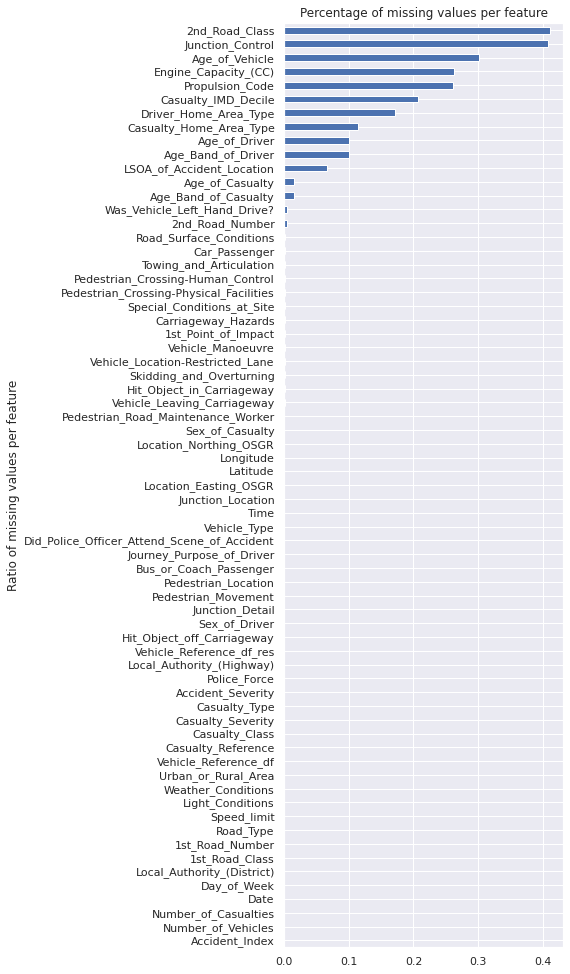

In [12]:
df_X.isna().mean().T.sort_values().plot(
    kind="barh", figsize=(5,17),
    title="Percentage of missing values per feature",
    xlabel="Ratio of missing values per feature");

In [13]:
df_X = df_X.dropna(thresh=df_X.shape[0] * 0.85, axis=1)
df_X.shape

(319790, 60)

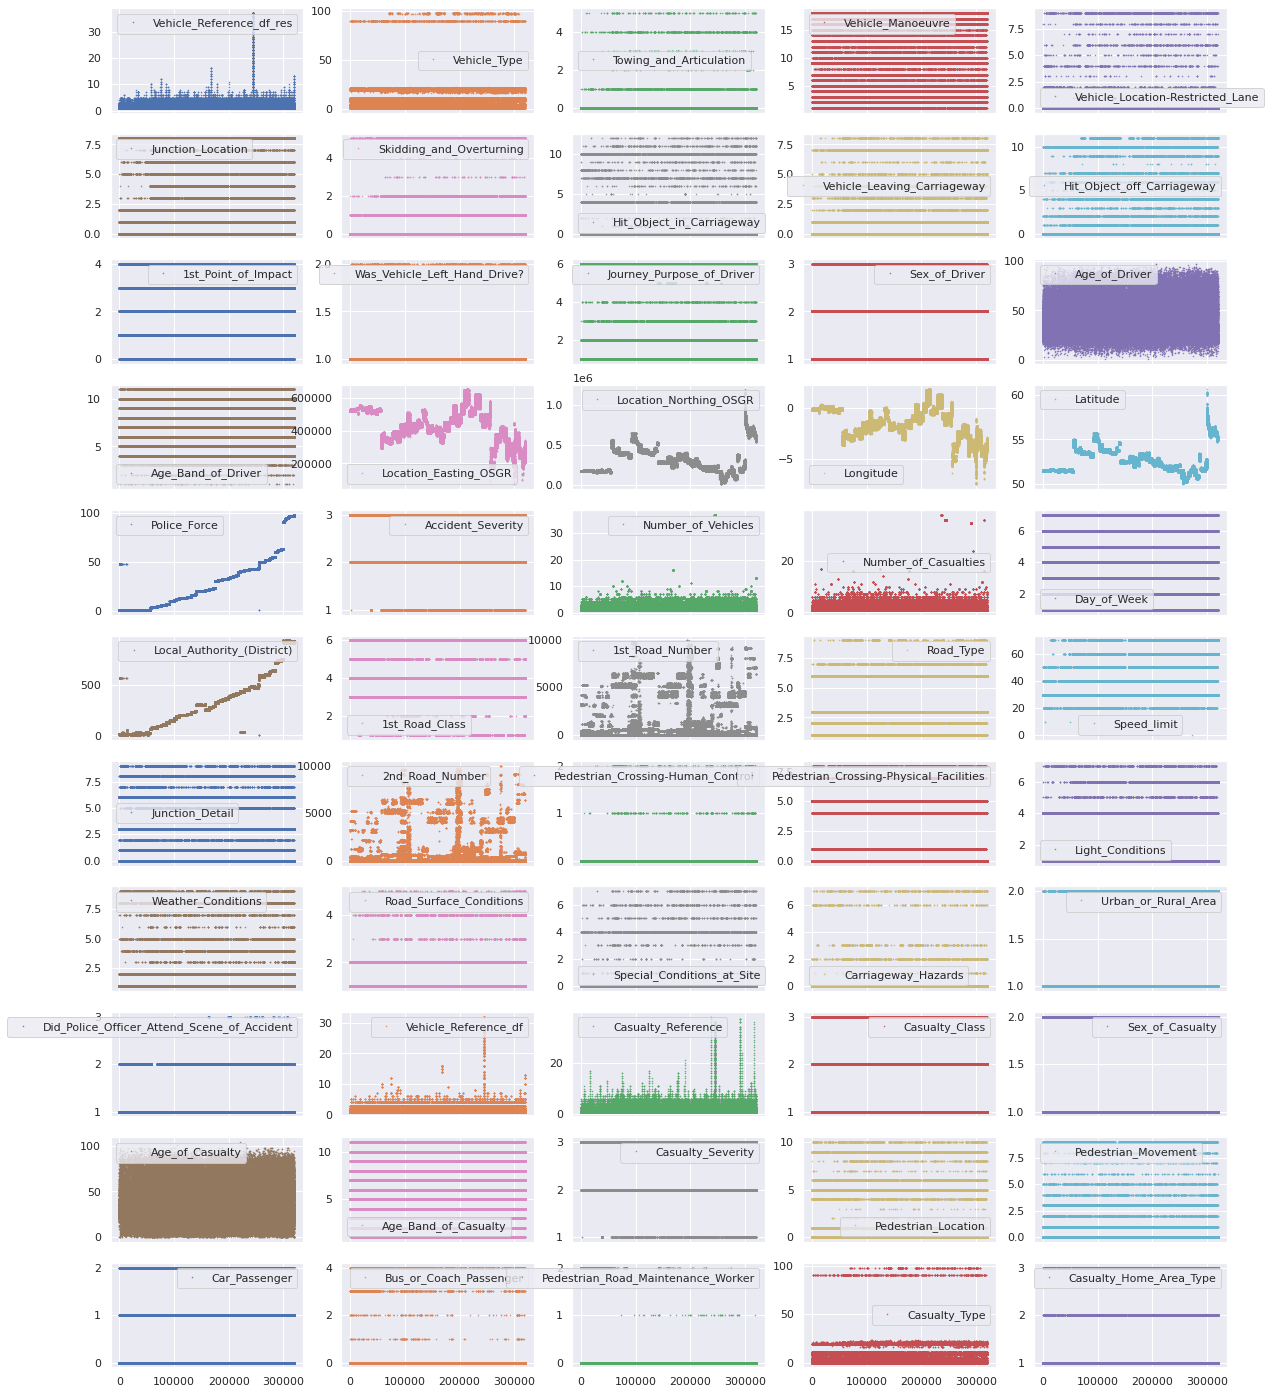

In [14]:
df_X.plot(lw=0, marker=".", subplots=True, layout=(-1, 5),
          figsize=(20,25), markersize=1)
plt.show()

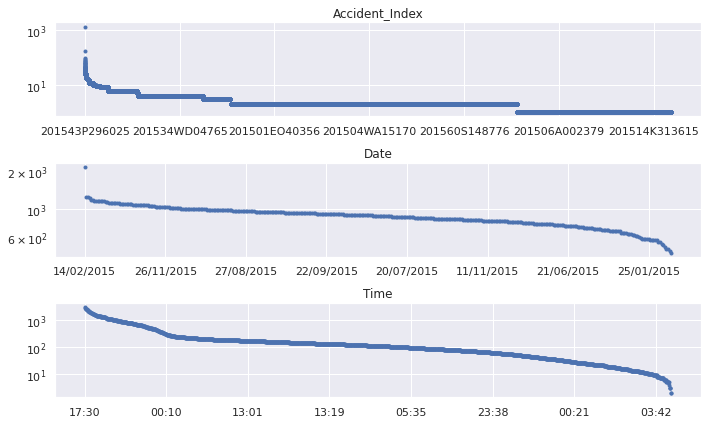

In [15]:
df_non_numerical = df_X.select_dtypes(exclude=["number", "datetime"])
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(10, 6))

for col, ax in zip(df_non_numerical.columns, axes.ravel()):
    df_non_numerical[col].value_counts().plot(logy=True, title=col, lw=0, marker=".", ax=ax)
plt.tight_layout();
plt.show()

**เนื่องจากอุบัติเหตุอาจจะเกิดวงกว้าง ทำให้ Accident_Indexซ้ำกันเยอะ เพราะมีหลายคนรวมอยู่ในเหตุการณ์ มันวิเคราะห์ยาก remove ออกไปก่อน**

In [16]:
accident_ids = df_non_numerical["Accident_Index"].value_counts().head(10).index
df_X = df_X[~df_X["Accident_Index"].isin(accident_ids)]
df_X.shape

(317665, 60)

### Data Distribution
- histogram ==> showed that some feature has one most frequent value, right skewed
- Most frequent entry

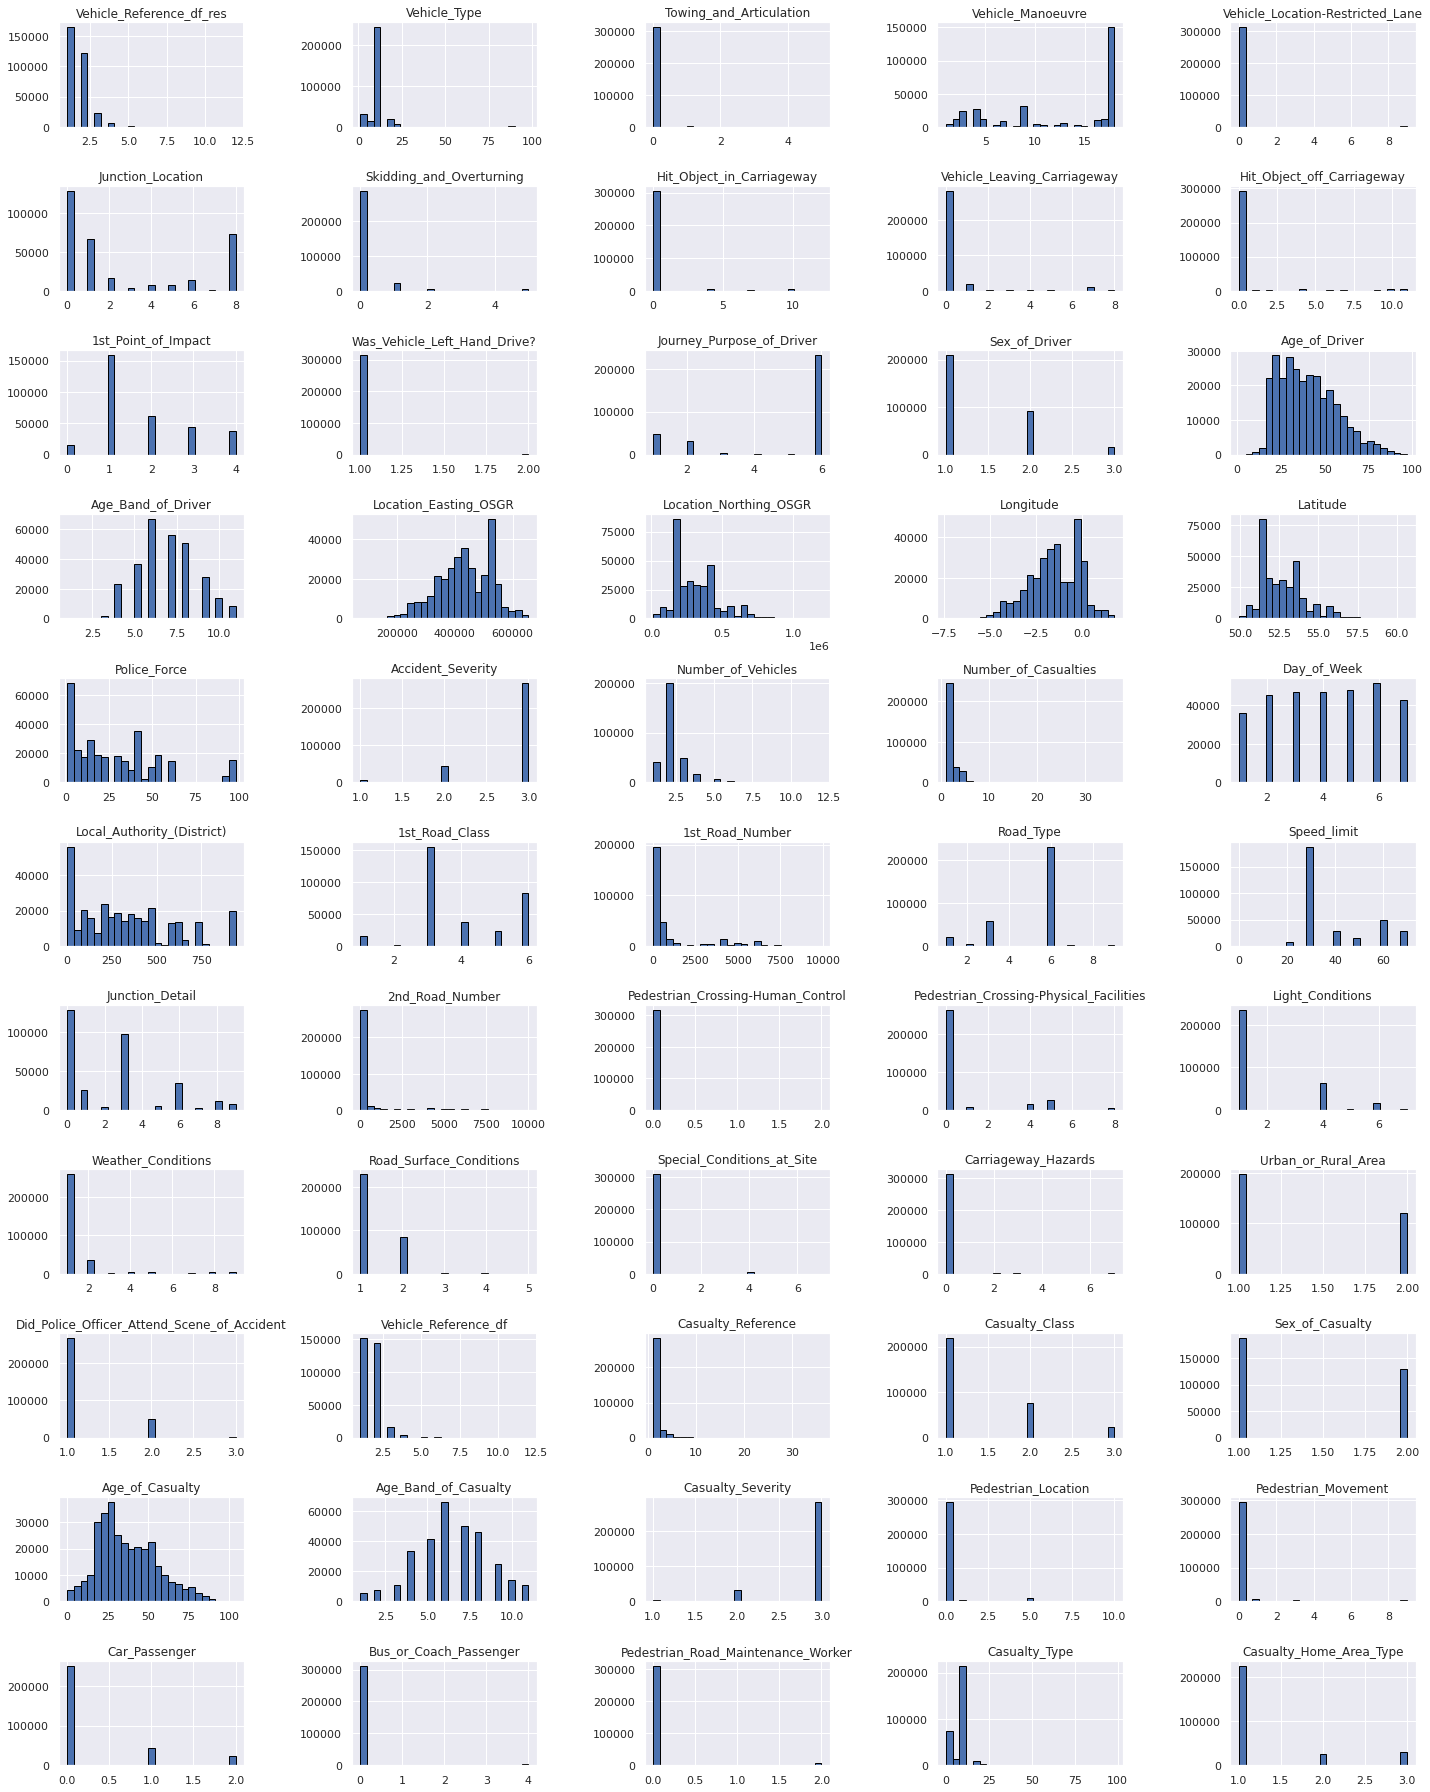

In [17]:
df_X.hist(bins=25, figsize=(20, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout()
plt.show()

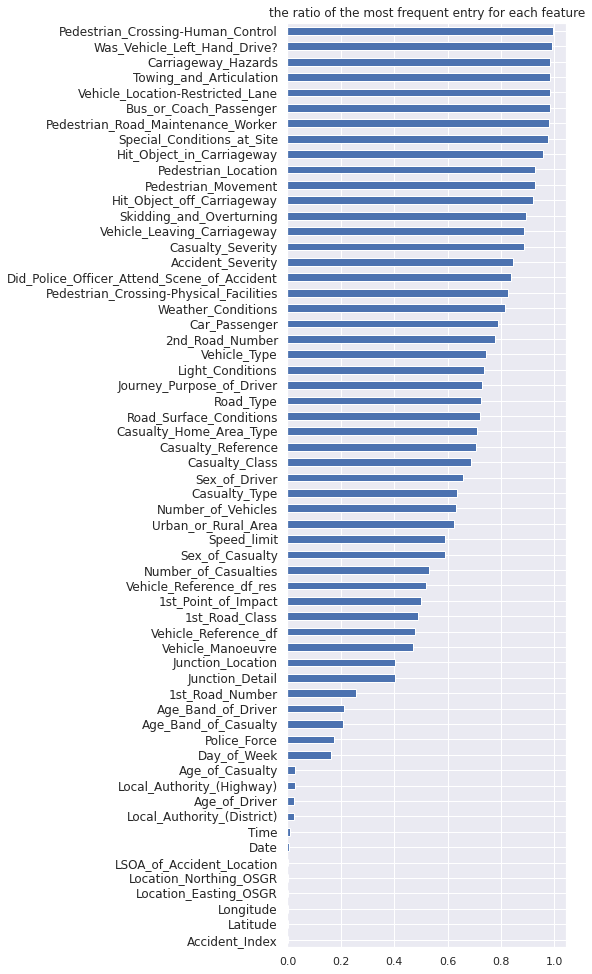

In [18]:
df_freq = df_X.eq(df_X.mode().values, axis=1).mean().sort_values(ascending=True)
df_freq.plot(kind='barh', figsize=(5,17))
plt.yticks(size=12)
plt.title('the ratio of the most frequent entry for each feature')
plt.show()

In [19]:
cols_continuous = df_X.select_dtypes(include="number").nunique() >= 25
df_continuous = df_X[cols_continuous[cols_continuous].index]
df_discrete = df_X[cols_continuous[~cols_continuous].index]

print('Dataframe of Continous values: ', df_continuous.shape)
print('Dataframe of Discrete values: ', df_discrete.shape)

Dataframe of Continous values:  (317665, 11)
Dataframe of Discrete values:  (317665, 44)


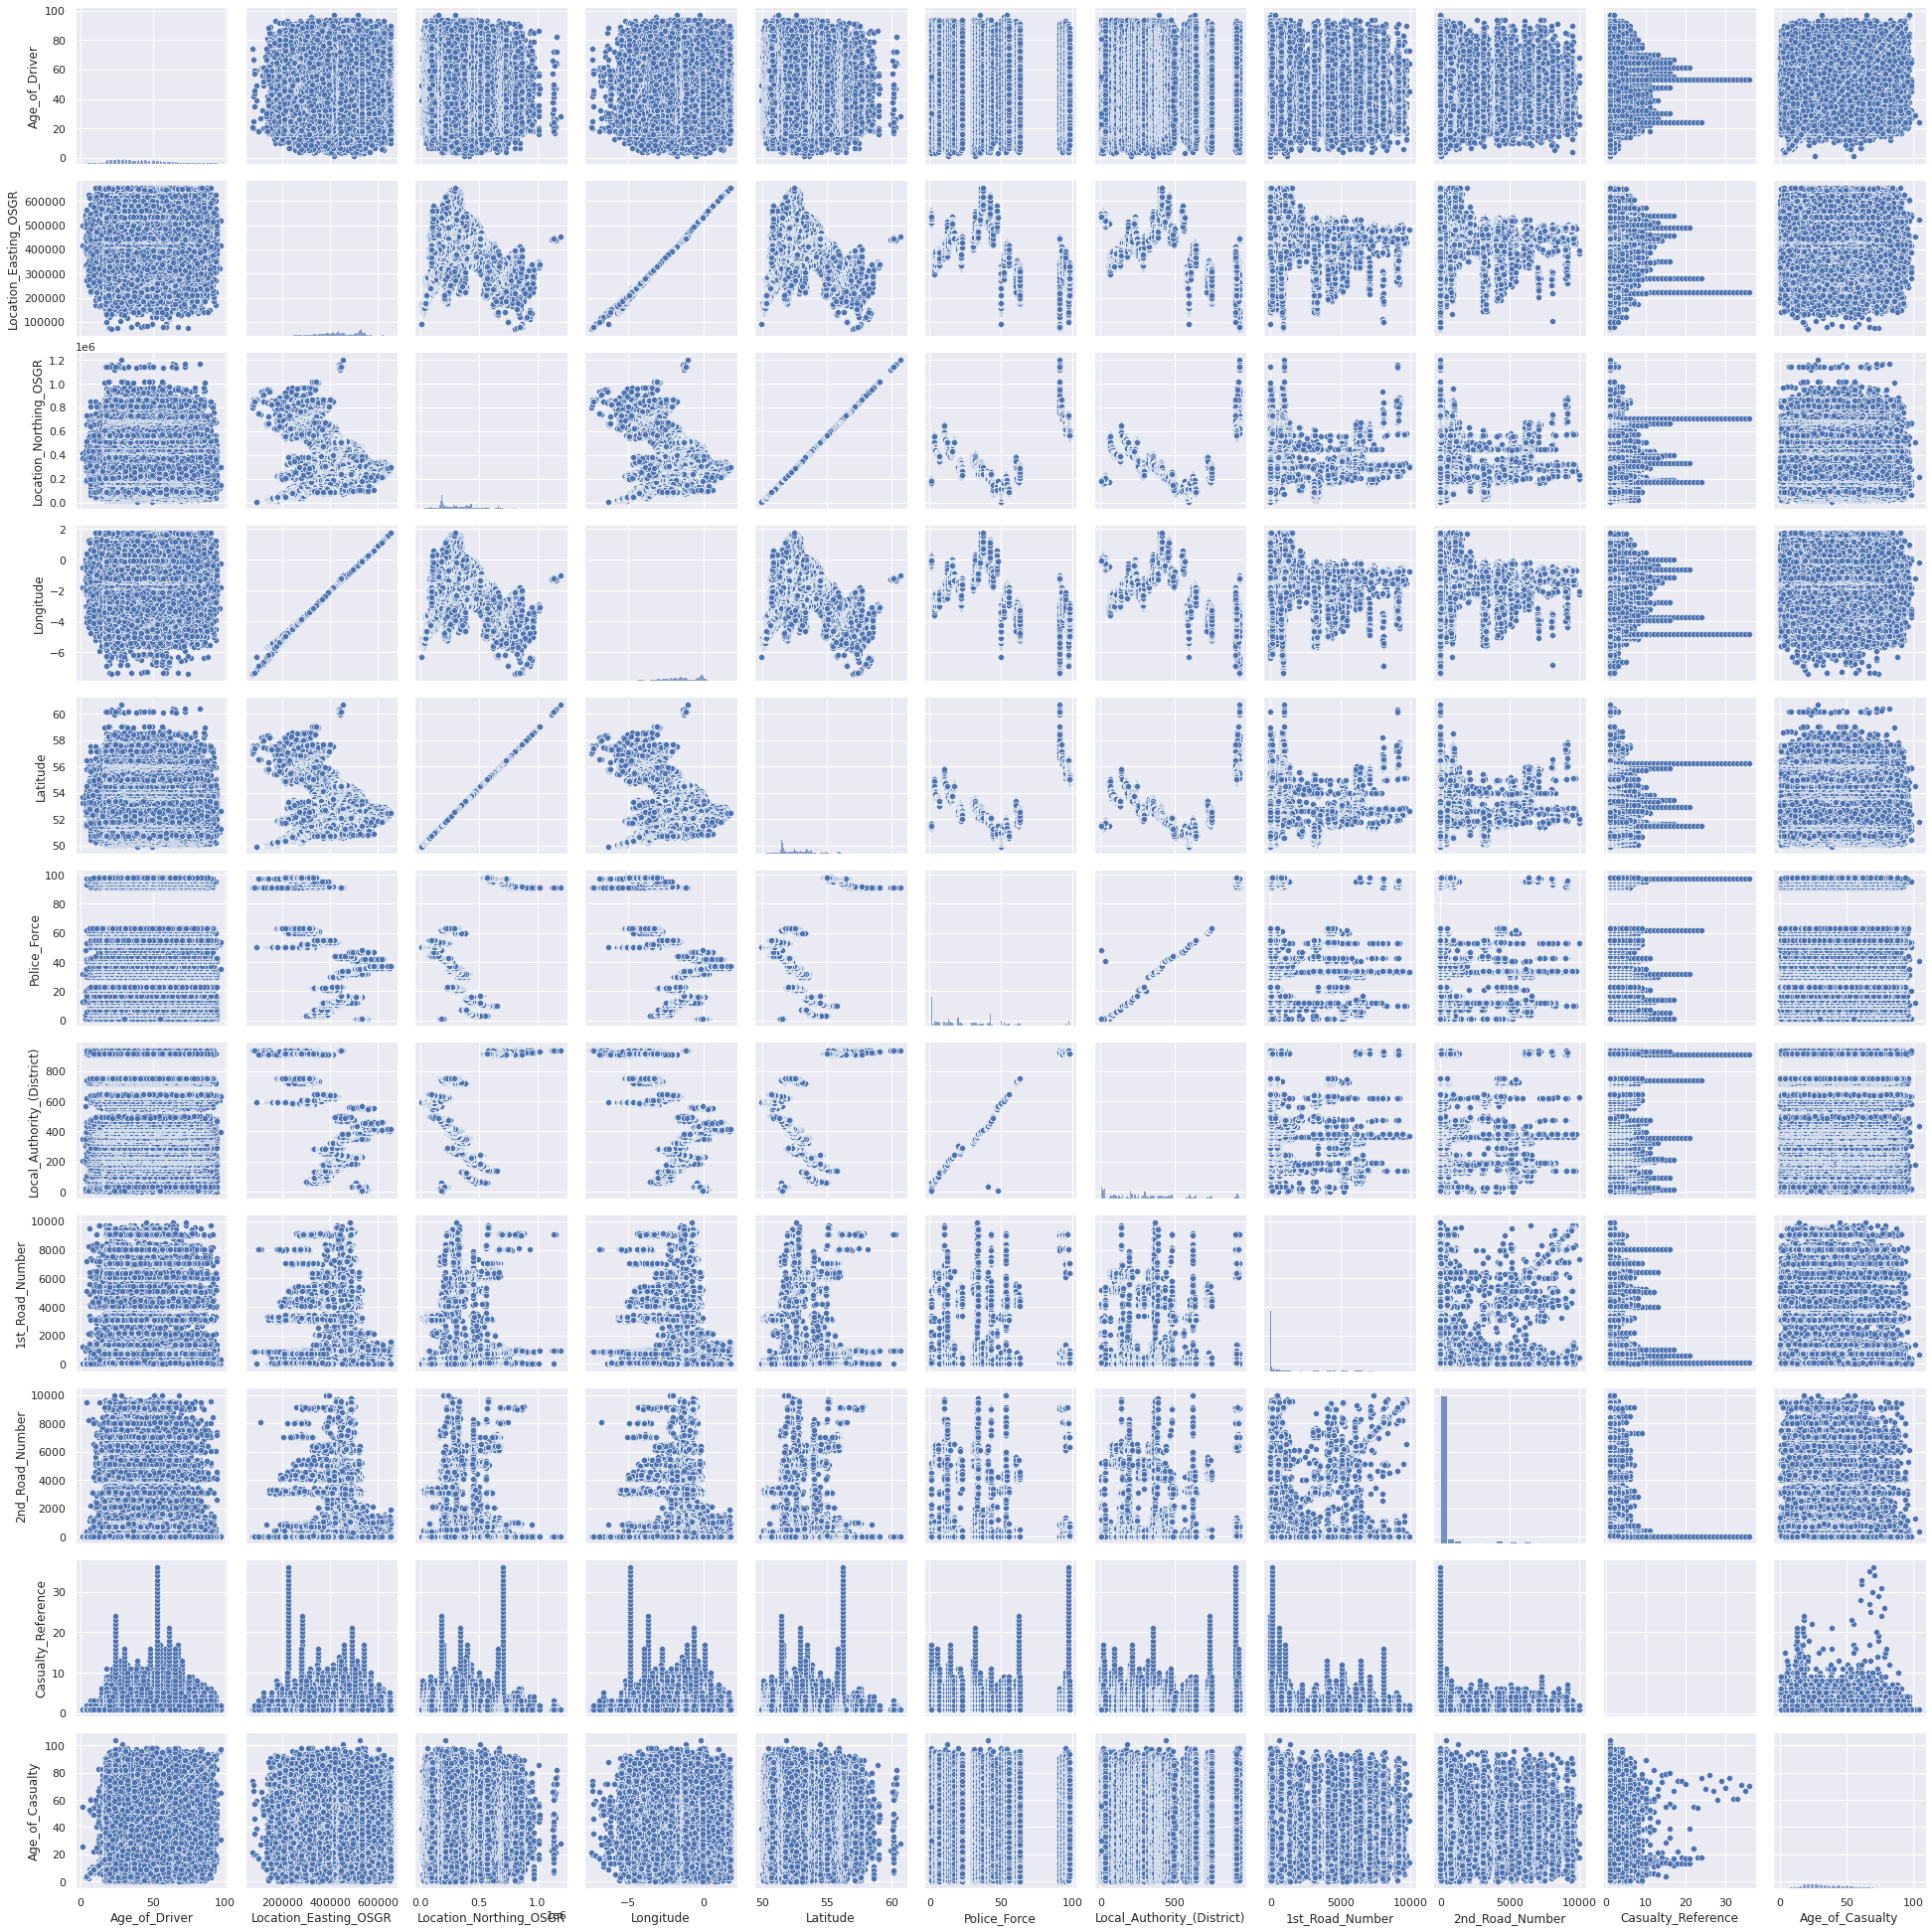

In [20]:
sns.pairplot(df_continuous.iloc[:, :])

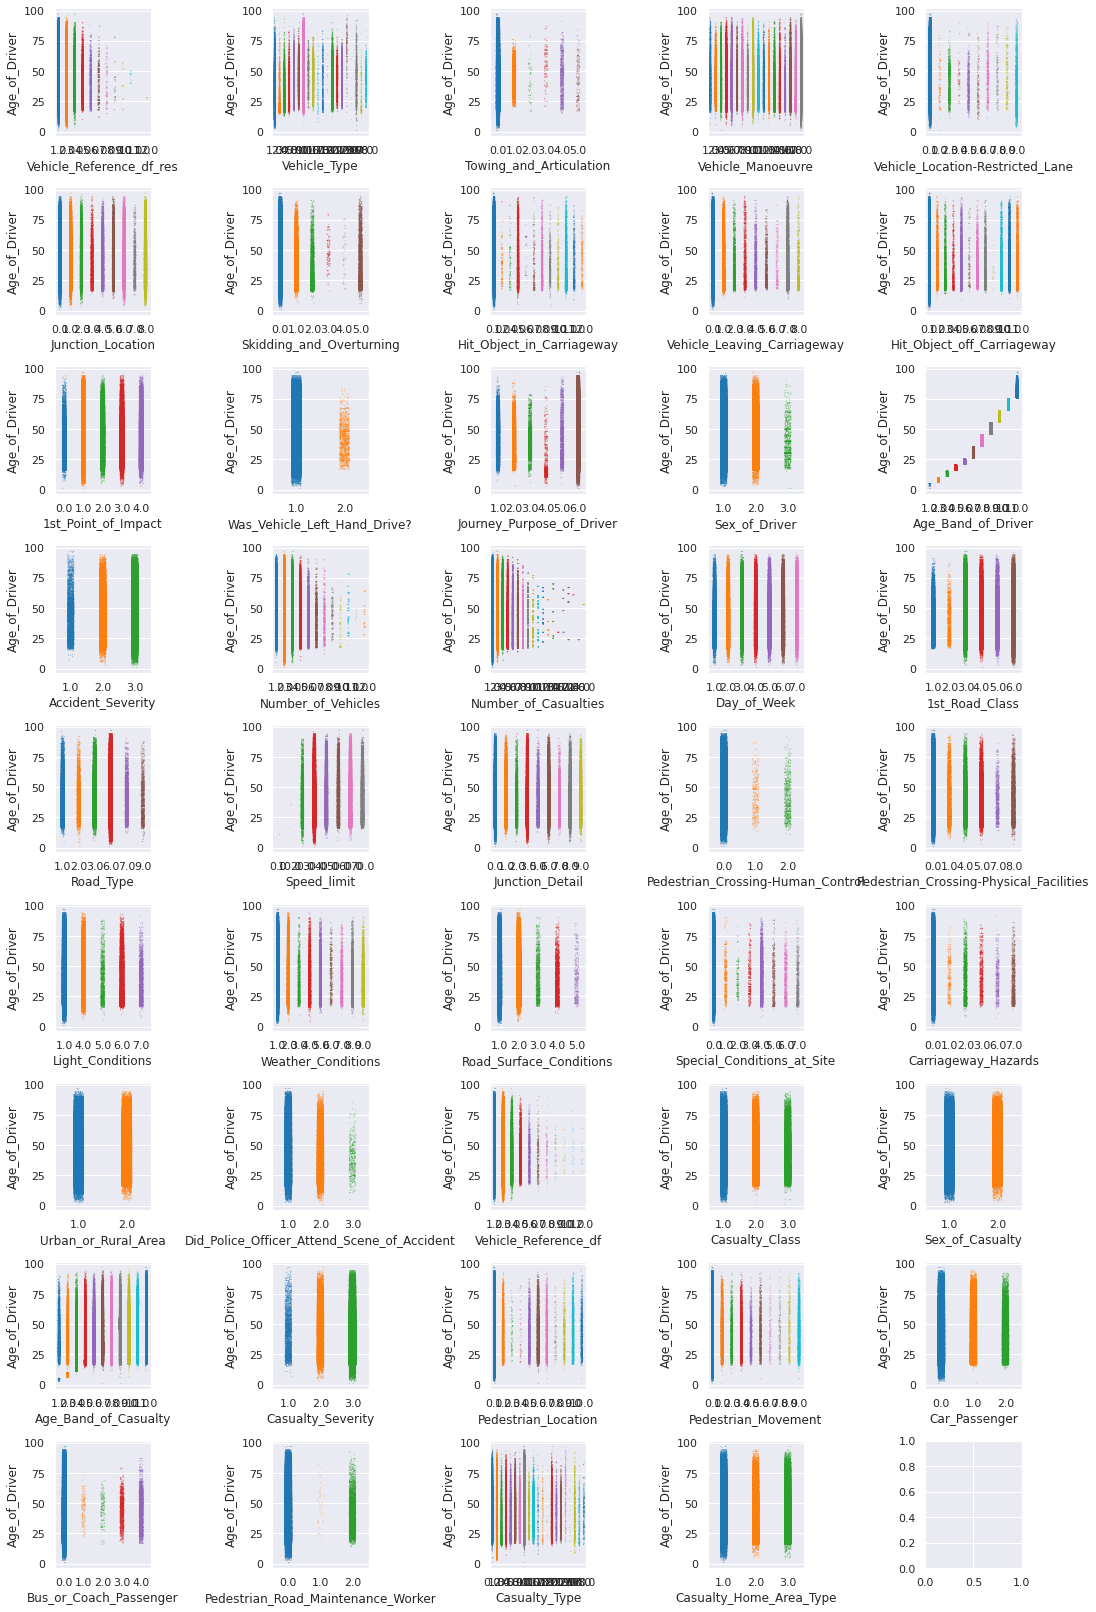

In [21]:
n_cols = 5
n_elements = len(df_discrete.columns)
n_rows = np.ceil(n_elements / n_cols).astype("int")
y_value = df_X["Age_of_Driver"]

fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(15, n_rows * 2.5))

for col, ax in zip(df_discrete.columns, axes.ravel()):
    sns.stripplot(data=df_X, x=col, y=y_value, ax=ax, palette="tab10", size=1, alpha=0.5)
plt.tight_layout();

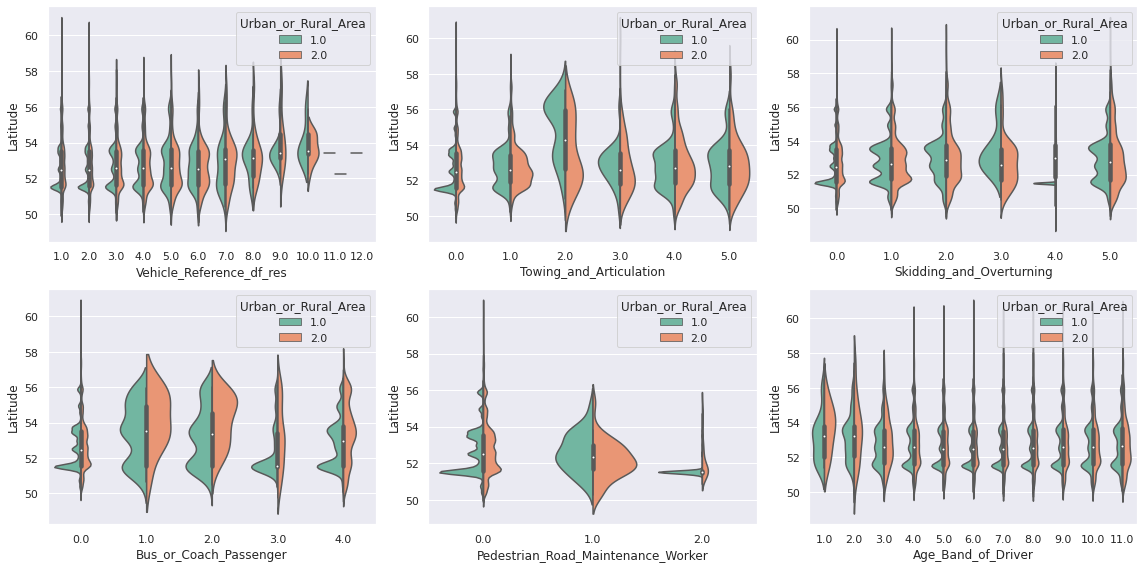

In [22]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 8))
selected_features = ["Vehicle_Reference_df_res", "Towing_and_Articulation",
                     "Skidding_and_Overturning", "Bus_or_Coach_Passenger",
                     "Pedestrian_Road_Maintenance_Worker", "Age_Band_of_Driver"]

for col, ax in zip(selected_features, axes.ravel()):
    sns.violinplot(data=df_X, x=col, y=df_X["Latitude"], palette="Set2",
                   split=True, hue="Urban_or_Rural_Area", ax=ax)
plt.tight_layout();

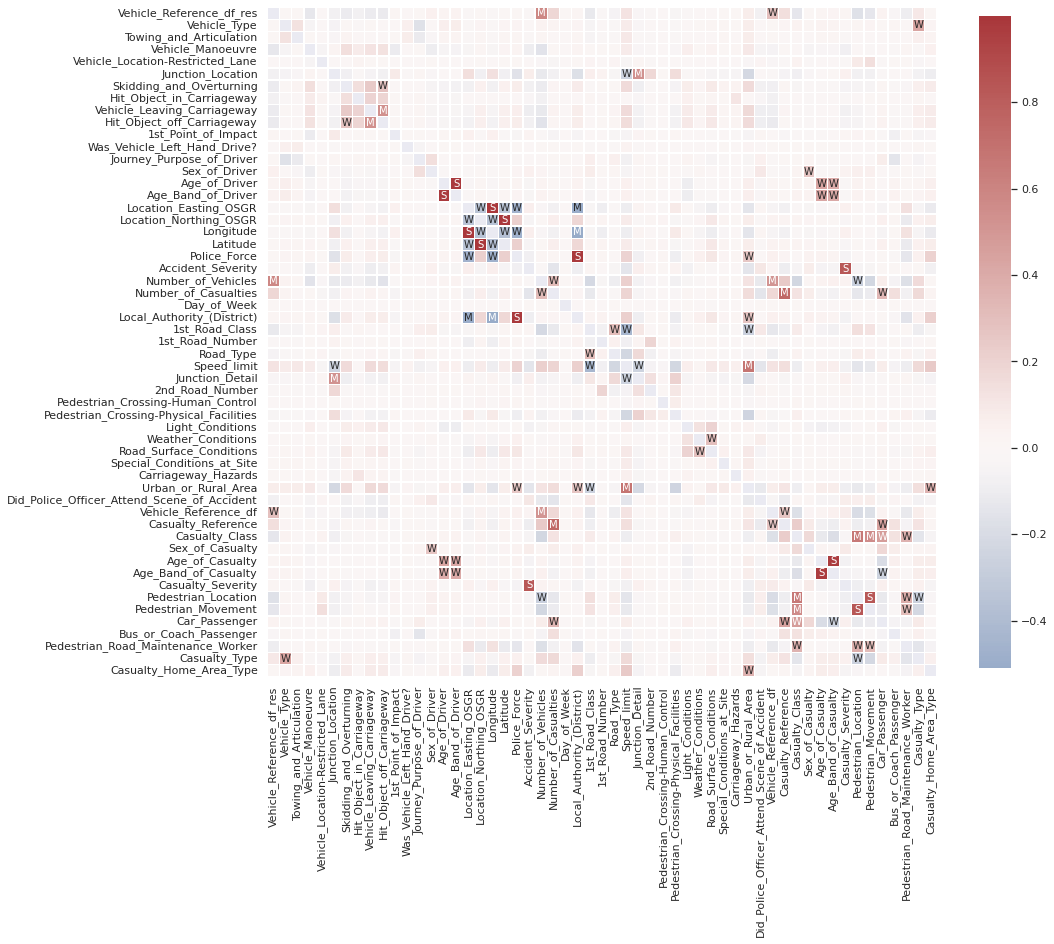

In [23]:
df_corr = df_X.corr()
# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});